# Energy transition

In the last notebook, we looked at how a logistic growth model could be applied to future uptake of solar and wind energy, but we made big assumptions.  

(1) Solar and wind are capable of filling our fossil fuel energy gap;  
(2) historical growth factors for solar and wind will continue into the future;  
(3) we guess the final mix of solar:wind (and other energy sources);  
(4) other technologies, such as batteries, are not limiting factors;   
(5) availability of raw materials will not limit uptake; and  
(6) human factors will not interfere with progress.

Are the assumptions likely or even plausible?  
(1) There is plenty of solar and wind energy available to provide all our energy needs, and there probably is a practical mix that is plausible everywhere by differing proportions of additional hydro, nuclear, biofuels, geothermal, and other low-carbon-dioxide-emission energy types. In 2019, 75% of newly-installed global electricity generation was renewable (REN21, 2020).  
(2) It seems plausible that growth factors that have been stable for 40 years (reflecting incremental science-technology-manufacturing improvements in generation units) might continue for another 20 years (maybe even increase due to scale of uptake).  
(3) It is clear from our model that details of the final mix don't matter that much, because if growth becomes anything close to as rapid as our prediction, then the final time to reach any final value is similar (the nature of exponential processes).  
(4), (5), and (6) almost certainly pose problems, but let's continue to calculate if the transition might be feasible. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

t = np.load('t.npy')
N = np.load('N.npy')
E = np.load('E.npy')
gdpPerCapita = np.load('gdpPerCapita.npy')
energyPerDollar = np.load('energyPerDollar.npy')

def logisticGrowthAnalytic(k,P,N0,t):
    '''
    Given the growth rate (k), carrying capacity (P), and initial population
    value (N0), generate an array of population (N) at various times (t), 
    based on analytical solution of the logistic growth equation. 
    Assumes k and P are not functions of t or N.

    Parameters
    ----------
    k : float
        Growth rate parameter.
    P : float
        Carrying capacity.
    N0 : float
        Initial population value (t=0).
    t : ndarray
        Time array.

    Returns
    -------
    N : ndarray
        Population value at time t

    '''
    return P / (1 + ((P-N0)/N0)*np.exp(-k*t))

## Energy consumtion in future: wind and solar
In previous notebooks we looked at strategies to predict future energy consumption. Let's revisit a specific model. It is likely not realistic, but may still be a useful thought experiment.

We estimate total energy consumption by assuming...   
(1) The UN medium fertility population estimate.  
(2) Linear growth in global GDP per capita.  
(3) Exponential decrease in the energy cost per GDP dollar.

We estimate the proportion provided by solar and wind by extrapolation of logistic growth models (see previous notebook).

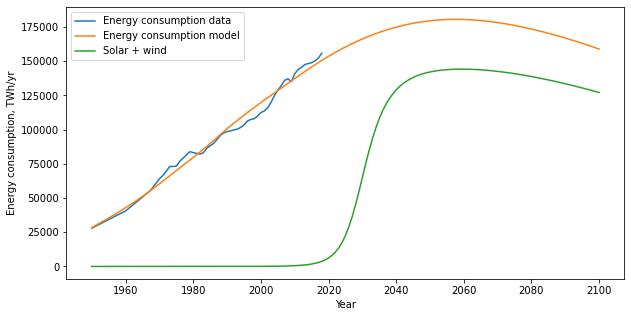

In [2]:
# Project forward GDP per capita as a linear model
select = np.logical_not(np.isnan(gdpPerCapita))
modelParameters = np.polyfit(t[select],gdpPerCapita[select],1)
modelFuncGdpPC = np.poly1d(modelParameters)
modelGDPperCapita = modelFuncGdpPC(t)

# Model exponential decrease with time of energy needed for each GDP dollar 
select = np.logical_not(np.isnan(energyPerDollar))
modelParameters = np.polyfit(t[select],np.log(energyPerDollar[select]),1)
modelFuncLogEnergyPerDollar = np.poly1d(modelParameters)
modelEnergyPerDollar = np.exp(modelFuncLogEnergyPerDollar(t))

modelE = modelEnergyPerDollar * modelGDPperCapita * N / 1000

proportionWind  = logisticGrowthAnalytic(0.20,0.3,0.0169,t-2018)
proportionSolar = logisticGrowthAnalytic(0.36,0.5,0.0078,t-2018)

modelEWind = modelE * proportionWind
modelESolar = modelE * proportionSolar
modelESolarAndWind = modelESolar + modelEWind

plt.figure(figsize=[10,5])
plt.plot(t, E, label='Energy consumption data')
plt.plot(t, modelE, label='Energy consumption model')
plt.plot(t, modelESolarAndWind, label='Solar + wind')
plt.xlabel('Year')
plt.ylabel('Energy consumption, TWh/yr')
plt.legend()
plt.show()

## Energy storage

We have been looking at energy consumption without considering how energy is used. About 80% of energy consumption is in the form of heat or movement (e.g. transport), rather than electricity (the focus of Solar PV, and windmill technology), but electricity can be used for heat and movement. Energy consumption is not necessarily in the same place or at the same time as energy generation. Storage of energy is needed.

Industrial electricity supply requires low-cost low-maintenance storage, whereas most electricity use (e.g. electric cars) requires storage with high-energy-density (low weight) and fast charging capability (e.g. Trahey et al., 2020). Both applications are now becoming feasible with lithium-based batteries, which are becomimg cheap: the levelized cost of energy (LCOE) for utility-scale (grid) Li battery installations dropped from 800 USD/MWh in 2013 to 200 USD/MWh in 2018 (BNEF, 2020). Other battery technologies or chemical energy storage (e.g. hydrogen) may become a reality in future, but let's start by considering the present front-runner: lithium (Li).

Typical battery storage built into a solar or wind power plant is equivalent to 4 hours of maximum generation capacity (BNEF, 2020). Let's take a simple model and assume 12.5% efficiency for solar and 25% for wind (IRENA, 2020), so storage equivalent to 4/0.125 = 32 hours of consumption. We can hence calculate how much storage we would need in any particular year, and the new amount of storage needed to be installed each year (the difference in storage capacity - the gradient of the line above).

New storage needs to be manufactured. Batteries used in Tesla cars contain about 170 g/kWh = 170,000 tonnes/TWh of lithium; and the theoretical minimum is 70-80 g/kWh (Martin, 2017).  

**How much lithium will need to be mined each year?**

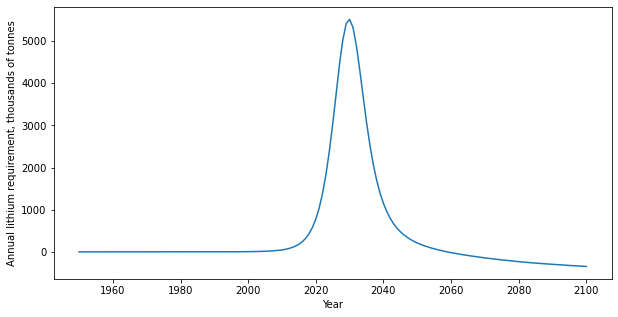

In [3]:
newESolar = np.gradient(modelESolar)
newEWind  = np.gradient(modelEWind)

hoursInYear = 365.24 * 24
storageNeededTWh = (newESolar/0.125 + newEWind/0.25) * 4 / hoursInYear

LiNeededThousandsOfTons = 170*storageNeededTWh

plt.figure(figsize=[10,5])
plt.plot(t, LiNeededThousandsOfTons)
plt.xlabel('Year')
plt.ylabel('Annual lithium requirement, thousands of tonnes')
plt.show()

**Is it feasible there is enough lithium in the world to meet this spike in demand, and we could mine it that quickly?** 

In 2018, 95,000 tonnes of Li was mined; in 2019, 77,000 tonnes was mined; and it is estimated that global reserves are about 17 million tonnes (USGS, 2020).  

Global production will have to increase by a factor of about 60 in the next decade to meet the projected peak in demand - and so far we have only been considering storage at electricity generation facilities.  


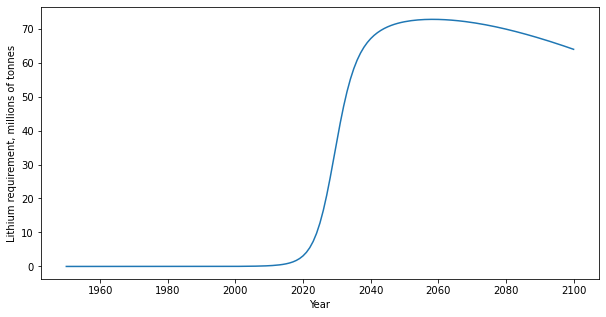

In [4]:
totalLithiumMillionsTons = np.cumsum(LiNeededThousandsOfTons)/1000

plt.figure(figsize=[10,5])
plt.plot(t, totalLithiumMillionsTons)
plt.xlabel('Year')
plt.ylabel('Lithium requirement, millions of tonnes')
plt.show()

## Reality check

It seems plausible that global lithium reserves could be increased by a factor of 5 if suitable exploration was undertaken, but it seems challenging to increase reserves and production by this magnitude in just one decade. 

In addition, we have ignored three important factors:  
(1) such a dramatic rate of transition requires people to cooperate at a large scale, which seems unlikely (incumbent industries/countries will fight change);  
(2) energy use is highly varied and there are sure to be alternative ways to store energy for some applications, and some, e.g. aviation, may **require** alternate energy storage; and  
(3) we have not considered all types of consumption. For example if 1 in 4 people require an electric car, then how much lithium would be needed? There is about 50 kg of Li in a typical electric car and we are forecast to peak at 10 billion people. Therefore, we would require an additional 125 million tonnes of Li to achieve the goal - nearly double what we just estimated for the generation side, and that is just considering cars. 

It is very likely that some other types of energy storage will be needed in addition to lithium, and this may be a significant limiting factor. This, combined with human resistance to change, is very likely to slow the transition down.

In [5]:
np.save('modelE.npy',modelE)
np.save('modelESolar.npy',modelESolar)
np.save('modelEWind.npy',modelEWind)

## References

BNEF, 2020. Battery Power’s Latest Plunge in Costs Threatens Coal, Gas. BloombergNEF.  
https://about.bnef.com/blog/battery-powers-latest-plunge-costs-threatens-coal-gas/

IRENA, 2020.  
https://www.irena.org/Statistics/View-Data-by-Topic/Capacity-and-Generation/Statistics-Time-Series  

Martin, P., 2017.  
https://www.linkedin.com/pulse/how-much-lithium-li-ion-vehicle-battery-paul-martin/

REN21, 2020. Renewables 2020 Global Status Report. Paris: REN21 Secretariat. ISBN 978-3-948393-00-7.  
https://www.ren21.net/gsr-2020/
https://www.ren21.net/reports/ren21-reports/  

Trahey et al., 2020. Energy storage emerging: A perspective from the Joint Center for Energy Storage Research. Proceedings of the National Academy of Sciences 117.23 (2020): 12550-12557.  
https://www.pnas.org/content/117/23/12550

USGS, 2020.  
https://pubs.usgs.gov/periodicals/mcs2020/mcs2020-lithium.pdf